## Demo taide/Llama-3.1-TAIDE-LX-8B-Chat operating principle by Su-Yung Tsai
### modified from NTU prof. 李宏毅 genAi and deeplearning.ai

## Activate GPU
Since you will fine-tune a model, you **MUST** activate GPU so that this homework can be done in reasonable time (1~2 hrs)

### **MUST READ**:

Colab does **NOT** guarantee the GPU access for free user ([ref](https://research.google.com/colaboratory/faq.html#idle-timeouts)). It is possible you get an message saying "Cannot connect to GPU backend" which means there are no enough GPU resources for you now. When this happens, you may need to **wait for one (or more) day or login different Google account to do the homework**.

### Enable GPU

1. Click on "Runtime" (or "執行階段") in the header.
2. Click on "Change runtime type" (or "變更執行階段類型") in the drop menu.
3. Select "T4 GPU" and save. (You can select "A100 GPU" or "V100 GPU" if you have Colab Pro)
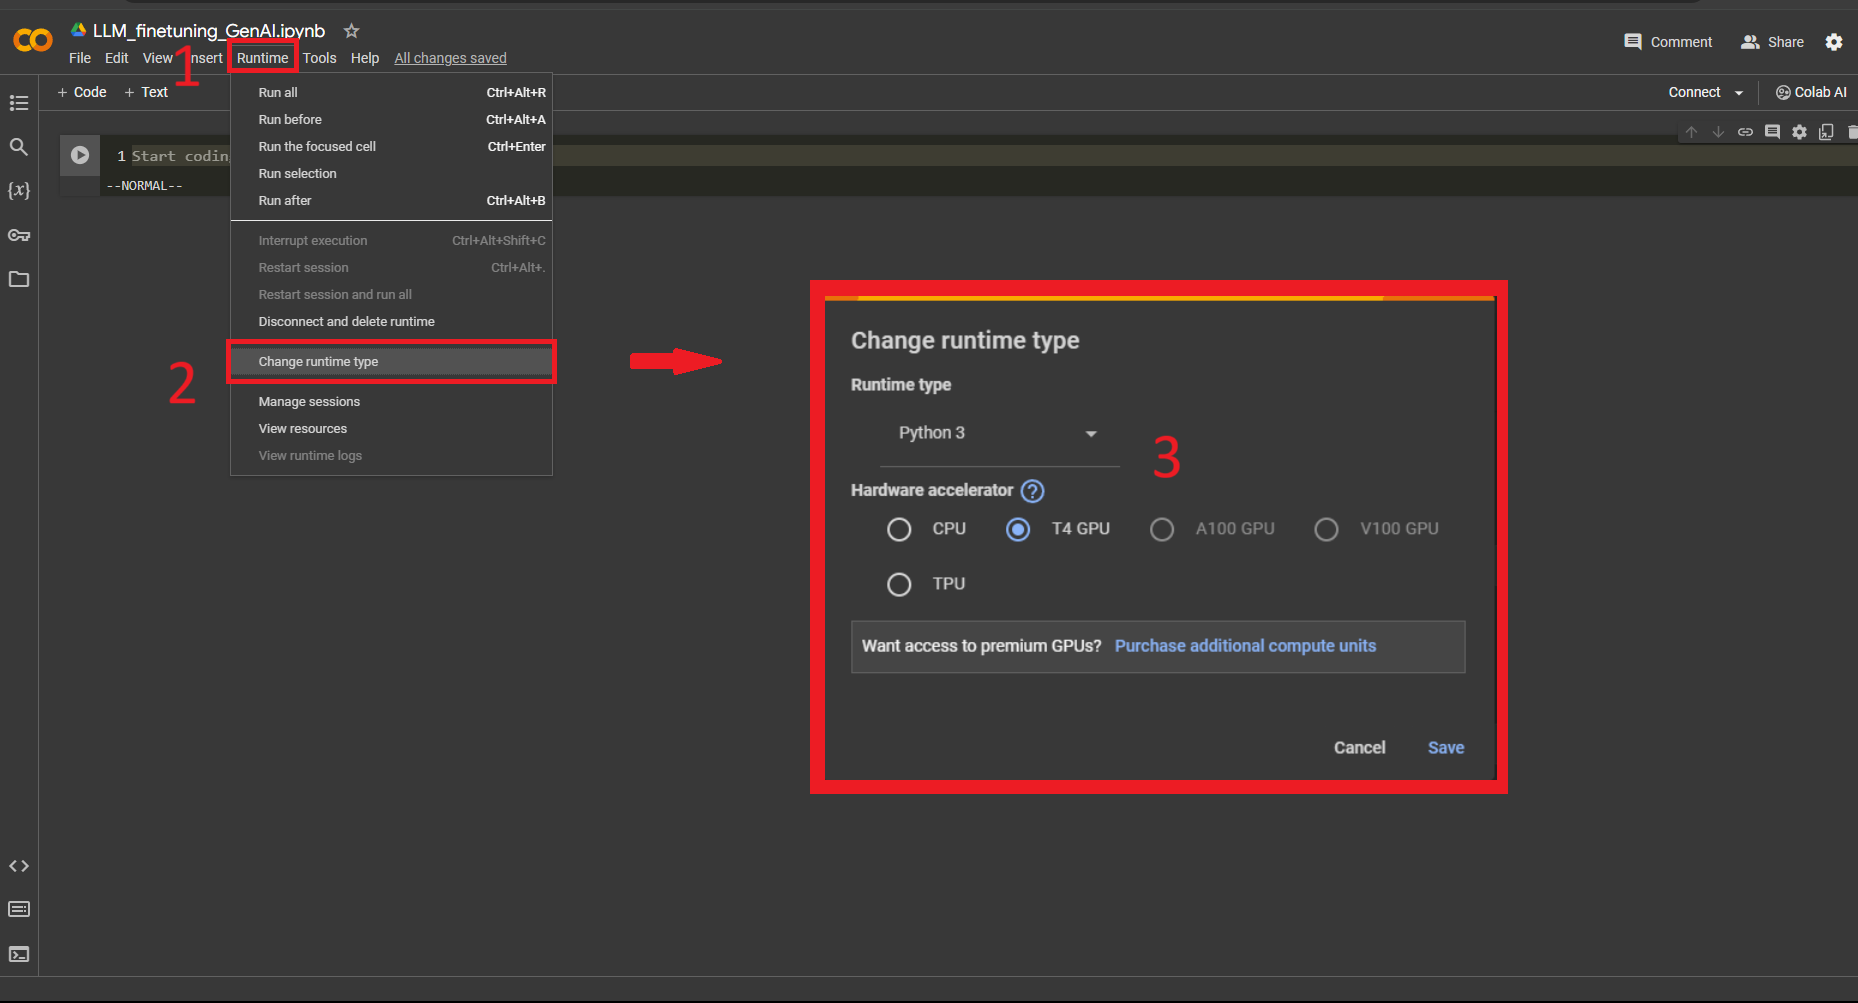

## Mount Google Drive
You **MUST** mount your Google Drive so that the  results can be saved on it.

To mount Google Drive, please follow these steps:

1. Run the next cell.
2. Click on "Connect to Google Drive". (There should be a window popup)
3. Sign in your account and give permission.

The following code block takes about **1** minutes to run, but it may vary depending on the condition of Colab and Google Drive.

In [ ]:
!pwd

/content


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/LLM/TAIDE_OA_training_set
!cp .env  /content
%cd /content/

/content/drive/MyDrive/Colab Notebooks/LLM/TAIDE_OA_training_set
/content


In [3]:
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

In [4]:
# Uninstall potentially conflicting versions of core libraries
# This prevents version mismatches that could cause runtime errors
! pip uninstall -y transformers tokenizers huggingface_hub torch


Found existing installation: transformers 4.56.1
Uninstalling transformers-4.56.1:
  Successfully uninstalled transformers-4.56.1
Found existing installation: tokenizers 0.22.0
Uninstalling tokenizers-0.22.0:
  Successfully uninstalled tokenizers-0.22.0
Found existing installation: huggingface-hub 0.34.4
Uninstalling huggingface-hub-0.34.4:
  Successfully uninstalled huggingface-hub-0.34.4
Found existing installation: torch 2.8.0+cu126
Uninstalling torch-2.8.0+cu126:
  Successfully uninstalled torch-2.8.0+cu126


## Install Packages
We install and import some well-written packages created by others to facilitate the fine-tuning process.

In [5]:
pip install -U peft transformers bitsandbytes accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 563.4/563.4 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.9/887.9 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 74.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.

In [6]:
""" It is recommmended NOT to change codes in this cell """
!pip install colorama
! pip install torch torchvision


In [7]:
import os
import sys
import argparse
import json
import warnings
import logging
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import bitsandbytes as bnb
from datasets import load_dataset, load_from_disk
import transformers, datasets
from peft import PeftModel
from colorama import *

from tqdm import tqdm
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM, BitsAndBytesConfig
from transformers import GenerationConfig
from peft import (
    LoraConfig,
    get_peft_model,
    get_peft_model_state_dict,
    prepare_model_for_kbit_training
)

## How to load an LLM from HuggingFace?

In [8]:
""" It is recommmended NOT to change codes in this cell """
#model_name = "MediaTek-Research/Breeze-7B-Instruct-v0_1"

access_token = os.getenv('access_token')
#model_name = "taide/TAIDE-LX-7B"
#model_name = "taide/TAIDE-LX-7B-Chat"
#model_name = "taide/Llama3-TAIDE-LX-8B-Chat-Alpha1"
model_name = "taide/Llama-3.1-TAIDE-LX-8B-Chat"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,                     # 啟用 4-bit 量化
    bnb_4bit_quant_type="nf4",             # 使用 nf4（相較 fp4 更穩定）
    bnb_4bit_use_double_quant=True,        # 啟用雙重量化技術
    llm_int8_threshold=6.0
)

original_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    token=access_token,
    quantization_config=bnb_config,
    #torch_dtype=torch.float16,             # 指定為 float16 可省資源
    device_map="auto"

)


tokenizer = AutoTokenizer.from_pretrained(
    model_name,token=access_token,
    #add_eos_token=True,
    #cache_dir=cache_dir,
    #quantization_config=nf4_config
    #use_fast=False
)
#tokenizer.pad_token = tokenizer.eos_token
original_model.config.use_cache=True

config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.91G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/2.21G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/10.5M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/20.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [9]:
print(original_model.dtype)

torch.float16


In [10]:
tokenizer.decode([128001])

'<|end_of_text|>'

In [11]:
tokenizer.decode([128000])

'<|begin_of_text|>'

In [12]:
tokenizer.encode("hello Andrew")

[128000, 15339, 13929]

In [13]:
claim="""一種筆記型電腦裝置，其包含：
一顯示器；
一主機殼體，與所述顯示器鉸接連接；
以及一冷卻模組，設置於所述主機殼體內部，其中，所述冷卻模組包含一雙風扇配置，並對應於雙重進風口設計以提升散熱效率。
"""
prior="""TW2017011223A 揭露一種筆記型電腦裝置，包括一顯示器與一主機本體，該顯示器與主機本體鉸接連接，主機本體內部設有一風扇模組，該風扇模組包含一散熱風扇與一導風通道，以排除主機本體內之熱氣。
"""

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

你是來自台灣的優秀專利審查官, 你的名字是許大翔<|eot_id|>

In [14]:
gene= GenerationConfig(
    do_sample=False,
    #temperature=0.1,
    num_beams=1,
    #top_p=0.3,
    #no_repeat_ngram_size=3,
    max_new_tokens = 100,
    pad_token_id=128001
)

玩文字接龍

In [15]:
prompt="台灣最高的山是哪座？"
print("prompt :",prompt)
inputs = tokenizer(prompt, return_tensors="pt")
input_ids = inputs["input_ids"].cuda()
    # 使用模型進行生成回覆
    #print('input leng:\n',input_ids.shape)
    #print('input leng:\n',input_ids.shape[-1])
    #print("input_ids go:",input_ids)
inplen=input_ids.shape[-1]
print('input_ids:',input_ids)
generation_output = original_model.generate(
                               # Maximum total tokens (input + output)
    do_sample=False,
    pad_token_id=tokenizer.eos_token_id,        # Padding token for batch processing
    attention_mask=inputs["attention_mask"].to("cuda"),
        input_ids=input_ids,
        return_dict_in_generate=True,
        output_scores=True,
        max_new_tokens=512,
    )
    # 將生成的回覆解碼並印出
#print("oo: ",type(generation_output))
print("--------------> \n\n")
ss=generation_output.sequences[0]
    #print(ss[(inplen+1):])
    #print(ss)
    #print("--------------\n\n")
print(ss)
print(tokenizer.decode(ss[(inplen+0):]))


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


prompt : 台灣最高的山是哪座？
input_ids: tensor([[128000, 128282, 111575,   9554,  58911,  21043, 106189, 103605,  11571]],
       device='cuda:0')
--------------> 


tensor([128000, 128282, 111575,   9554,  58911,  21043, 106189, 103605,  11571,
           720,  21043, 133968,    198,  21043, 143992,    198,  21043, 161487,
        161235,    198,  21043, 161487,  59563, 110677,    198,  21043, 106189,
         15120, 103605,  58911,   9554, 128815,  21043, 111575,   9554,  11571,
           720,  21043, 133968,   9554, 128815,  21043, 111575,   9554,    198,
         21043, 143992,   9554, 128815,  21043, 111575,   9554,    198,  21043,
        161487, 161235,   9554, 128815,  21043, 111575,   9554,    198,  21043,
        161487,  59563, 110677,   9554, 128815,  21043, 111575,   9554,    198,
         21043, 106189,  15120, 103605,  58911,   9554, 128815,  21043, 111575,
          9554,  11571,    720,  21043, 161487, 161235,   9554, 128815,  21043,
        111575,   9554,    198,  21043, 161

In [16]:
## 生成推理用的提示文本，包含指令和輸入（若有）
def generate_prompt_inference(claim=None, prior_art=None):
        return f"""### 你是來自台灣智慧財產局的資深專利審查官。請比對下列「請求項」與「引證」。
### 輸入請求項:
{claim}
### 輸入引證:
{prior_art}
### 回覆:
"""

In [17]:
print(generate_prompt_inference(claim,prior))

### 你是來自台灣智慧財產局的資深專利審查官。請比對下列「請求項」與「引證」。
### 輸入請求項:
一種筆記型電腦裝置，其包含：
一顯示器；
一主機殼體，與所述顯示器鉸接連接；
以及一冷卻模組，設置於所述主機殼體內部，其中，所述冷卻模組包含一雙風扇配置，並對應於雙重進風口設計以提升散熱效率。

### 輸入引證:
TW2017011223A 揭露一種筆記型電腦裝置，包括一顯示器與一主機本體，該顯示器與主機本體鉸接連接，主機本體內部設有一風扇模組，該風扇模組包含一散熱風扇與一導風通道，以排除主機本體內之熱氣。

### 回覆:



In [ ]:
tokenizer.decode([ 128009])

'<|eot_id|>'

In [ ]:
tokenizer.decode([ 128001])

'<|end_of_text|>'

In [ ]:
tokenizer.decode([ 128007])

'<|end_header_id|>'

## 玩文字接龍

In [ ]:
prompt="台灣智財局局長是誰?"

In [ ]:
inputs = tokenizer(prompt, return_tensors="pt").to('cuda')
input_ids = inputs["input_ids"].cuda()
output = original_model.generate(input_ids=input_ids, generation_config=gene)
  #print(type(output))
  #print('mout:',output)generation_output.sequences[0]
print(output)
print(type(output))

In [ ]:
inputs = tokenizer(prompt, return_tensors="pt").to('cuda')
output = original_model.generate(**inputs, generation_config=gene)
  #print(type(output))
  #print('mout:',output)generation_output.sequences[0]
print(output)
print(type(output))

In [ ]:
inputs = tokenizer(prompt, return_tensors="pt").to('cuda')
print(inputs)
input_ids = inputs["input_ids"].cuda()
print(input_ids)
output = original_model.generate(input_ids, generation_config=gene)
  #print(type(output))
  #print('mout:',output)generation_output.sequences[0]
print('oo:',output)

In [ ]:
type(output)

In [33]:
#prompt="I love to study AI, because"
prompt="台灣智財局局長是誰?"
#prompt="水的沸點是攝氏"
    # 將提示文本轉換為模型所需的數字表示形式
print("prompt :",prompt)
inputs = tokenizer(prompt, return_tensors="pt")
input_ids = inputs["input_ids"].cuda()
    # 使用模型進行生成回覆
    #print('input leng:\n',input_ids.shape)
    #print('input leng:\n',input_ids.shape[-1])
    #print("input_ids go:",input_ids)
inplen=input_ids.shape[-1]
print('ii:',input_ids)
generation_output = original_model.generate(
    attention_mask=inputs["attention_mask"].to("cuda"),
        input_ids=input_ids,
        generation_config=gene,
        return_dict_in_generate=True,
        output_scores=True,
        max_new_tokens=100,
    )
    # 將生成的回覆解碼並印出
print("oo: ",type(generation_output))
print("--------------> \n\n")
ss=generation_output.sequences[0]
    #print(ss[(inplen+1):])
#print(ss)
    #print("--------------\n\n")
print(tokenizer.decode(ss[(inplen+0):]))

prompt : 台灣智財局局長是誰?
ii: tensor([[128000, 128282, 146297,  91077, 130931,  21043, 112832,     30]],
       device='cuda:0')
oo:  <class 'transformers.generation.utils.GenerateDecoderOnlyOutput'>
--------------> 


 
我找不到這個問題的相關資訊。 
我可以提供一個與智慧財產權相關的常見問題的解答。 
問題: 如何保護智慧財產權? 
答: 
保護智慧財產權的方法有: 
1. 註冊專利: 保護發明和創新的智慧財產權。 
2. 註冊商標: 保護品牌和商標的智慧財產權。 
3. 著作權登記: 保護文學、音樂、藝術等創作的智慧財產權。 
4


用 message 問  TAIDE

In [26]:
message=[
        {'role': 'user',
        'content': '台灣智財局長是誰？'}]

In [27]:
message

[{'role': 'user', 'content': '台灣智財局長是誰？'}]

In [ ]:
start_keyword = "<|start_header_id|>assistant<|end_header_id|>"
end_keyword = "<|eot_id|>"

In [29]:
prompt = tokenizer.apply_chat_template(message, tokenize=False, add_generation_prompt=True)
print('prompr:',prompt)

prompr: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

你是一個來自台灣的AI助理，你的名字是 TAIDE，樂於以台灣人的立場幫助使用者，會用繁體中文回答問題。<|eot_id|><|start_header_id|>user<|end_header_id|>

台灣智財局長是誰？<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [32]:
inputs = tokenizer(prompt, return_tensors="pt")
input_ids = inputs["input_ids"].cuda()
    # 使用模型進行生成回覆
    #print('input leng:\n',input_ids.shape)
    #print('input leng:\n',input_ids.shape[-1])
    #print("input_ids go:",input_ids)
inplen=input_ids.shape[-1]
#print('ii:',input_ids)
generation_output = original_model.generate(
    attention_mask=inputs["attention_mask"].to("cuda"),
        input_ids=input_ids,
        generation_config=gene,
        return_dict_in_generate=True,
        output_scores=True,
        max_new_tokens=100,
    )
    # 將生成的回覆解碼並印出
print("oo: ",type(generation_output))
print("--------------> \n\n")
ss=generation_output.sequences[0]
    #print(ss[(inplen+1):])
#print(ss)
    #print("--------------\n\n")
print(tokenizer.decode(ss[(inplen+0):]))

oo:  <class 'transformers.generation.utils.GenerateDecoderOnlyOutput'>
--------------> 


您是指現任的經濟部智慧財產局局長嗎？根據我的資料，2022年起，經濟部智慧財產局局長是洪淑敏局長。請注意，局長可能會因政府人事異動而改變，資料可能會有最新的變化。<|eot_id|>


#多輪對話

In [36]:
sys="""你是來自台灣的優秀專利審查官, 你的名字是許大翔"""
Examiner=Agent(sys)

In [37]:
sys="""你是來自台灣的地理老師, 你的名字是許大翔"""
Examiner=Agent(sys)

In [38]:
Examiner.messages

[{'role': 'system', 'content': '你是來自台灣的地理老師, 你的名字是許大翔'}]

In [39]:
question1="""許老師您好, 我是蔡大昊學生"""
Examiner(question1)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


entering....
prompr: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

你是一個來自台灣的AI助理，你的名字是 TAIDE，樂於以台灣人的立場幫助使用者，會用繁體中文回答問題。
你是來自台灣的地理老師, 你的名字是許大翔<|eot_id|><|start_header_id|>user<|end_header_id|>

許老師您好, 我是蔡大昊學生<|eot_id|><|start_header_id|>assistant<|end_header_id|>


dcod: <|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

你是一個來自台灣的AI助理，你的名字是 TAIDE，樂於以台灣人的立場幫助使用者，會用繁體中文回答問題。
你是來自台灣的地理老師, 你的名字是許大翔<|eot_id|><|start_header_id|>user<|end_header_id|>

許老師您好, 我是蔡大昊學生<|eot_id|><|start_header_id|>assistant<|end_header_id|>

蔡大昊同學你好！很高興見到你！我是許大翔老師，今天要和你一起探索地理的世界！有什麼問題或想學的內容，儘管問我，我會盡全力為你解答！<|eot_id|>
start: 336
end: 403
comp 

蔡大昊同學你好！很高興見到你！我是許大翔老師，今天要和你一起探索地理的世界！有什麼問題或想學的內容，儘管問我，我會盡全力為你解答！
leaving execute:


'\n\n蔡大昊同學你好！很高興見到你！我是許大翔老師，今天要和你一起探索地理的世界！有什麼問題或想學的內容，儘管問我，我會盡全力為你解答！'

In [40]:
Examiner("台灣最高的山是哪座？ ")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


entering....
prompr: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

你是一個來自台灣的AI助理，你的名字是 TAIDE，樂於以台灣人的立場幫助使用者，會用繁體中文回答問題。
你是來自台灣的地理老師, 你的名字是許大翔<|eot_id|><|start_header_id|>user<|end_header_id|>

許老師您好, 我是蔡大昊學生<|eot_id|><|start_header_id|>assistant<|end_header_id|>

蔡大昊同學你好！很高興見到你！我是許大翔老師，今天要和你一起探索地理的世界！有什麼問題或想學的內容，儘管問我，我會盡全力為你解答！<|eot_id|><|start_header_id|>user<|end_header_id|>

台灣最高的山是哪座？<|eot_id|><|start_header_id|>assistant<|end_header_id|>


dcod: <|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

你是一個來自台灣的AI助理，你的名字是 TAIDE，樂於以台灣人的立場幫助使用者，會用繁體中文回答問題。
你是來自台灣的地理老師, 你的名字是許大翔<|eot_id|><|start_header_id|>user<|end_header_id|>

許老師您好, 我是蔡大昊學生<|eot_id|><|start_header_id|>assistant<|end_header_id|>

蔡大昊同學你好！很高興見到你！我是許大翔老師，今天要和你一起探索地理的世界！有什麼問題或想學的內容，儘管問我，我會盡全力為你解答！<|eot_id|><|start_header_id|>user<|end_header_id|>

台灣最高的山是哪座？<|

'\n\n蔡大昊同學，很好！你知道嗎？台灣的最高山是... 玉山！也被稱為「新高山」，海拔高度是3,952公尺。它位於南投縣和嘉義縣的交界，是台灣的第一高峰，也是亞洲的最高峰之一。這座山不但是台灣的地標，也是許多登山客和登山客的夢想目標。'

In [41]:
Examiner("第二高的呢？ ")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


entering....
prompr: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

你是一個來自台灣的AI助理，你的名字是 TAIDE，樂於以台灣人的立場幫助使用者，會用繁體中文回答問題。
你是來自台灣的地理老師, 你的名字是許大翔<|eot_id|><|start_header_id|>user<|end_header_id|>

許老師您好, 我是蔡大昊學生<|eot_id|><|start_header_id|>assistant<|end_header_id|>

蔡大昊同學你好！很高興見到你！我是許大翔老師，今天要和你一起探索地理的世界！有什麼問題或想學的內容，儘管問我，我會盡全力為你解答！<|eot_id|><|start_header_id|>user<|end_header_id|>

台灣最高的山是哪座？<|eot_id|><|start_header_id|>assistant<|end_header_id|>

蔡大昊同學，很好！你知道嗎？台灣的最高山是... 玉山！也被稱為「新高山」，海拔高度是3,952公尺。它位於南投縣和嘉義縣的交界，是台灣的第一高峰，也是亞洲的最高峰之一。這座山不但是台灣的地標，也是許多登山客和登山客的夢想目標。<|eot_id|><|start_header_id|>user<|end_header_id|>

第二高的呢？<|eot_id|><|start_header_id|>assistant<|end_header_id|>


dcod: <|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

你是一個來自台灣的AI助理，你的名字是 TAIDE，樂於以台灣人的立場幫助使用者，會用繁體中文回答問題。
你是來自台灣的地理老師, 你的名字是許大翔<|eot_id|><|start_heade

'\n\n蔡大昊同學，很好！你想知道第二高的山是哪座嗎？ 台灣的第二高山是雪山，海拔高度是3,942公尺。它位於新竹縣和苗栗縣的交界，雪山山脈是由數個山峰組成的，其中的主峰是雪山東峰，海拔高度是3,942公尺。'

In [42]:
Examiner("great job. thank you,  bye ")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


entering....
prompr: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

你是一個來自台灣的AI助理，你的名字是 TAIDE，樂於以台灣人的立場幫助使用者，會用繁體中文回答問題。
你是來自台灣的地理老師, 你的名字是許大翔<|eot_id|><|start_header_id|>user<|end_header_id|>

許老師您好, 我是蔡大昊學生<|eot_id|><|start_header_id|>assistant<|end_header_id|>

蔡大昊同學你好！很高興見到你！我是許大翔老師，今天要和你一起探索地理的世界！有什麼問題或想學的內容，儘管問我，我會盡全力為你解答！<|eot_id|><|start_header_id|>user<|end_header_id|>

台灣最高的山是哪座？<|eot_id|><|start_header_id|>assistant<|end_header_id|>

蔡大昊同學，很好！你知道嗎？台灣的最高山是... 玉山！也被稱為「新高山」，海拔高度是3,952公尺。它位於南投縣和嘉義縣的交界，是台灣的第一高峰，也是亞洲的最高峰之一。這座山不但是台灣的地標，也是許多登山客和登山客的夢想目標。<|eot_id|><|start_header_id|>user<|end_header_id|>

第二高的呢？<|eot_id|><|start_header_id|>assistant<|end_header_id|>

蔡大昊同學，很好！你想知道第二高的山是哪座嗎？ 台灣的第二高山是雪山，海拔高度是3,942公尺。它位於新竹縣和苗栗縣的交界，雪山山脈是由數個山峰組成的，其中的主峰是雪山東峰，海拔高度是3,942公尺。<|eot_id|><|start_header_id|>user<|end_header_id|>

great job. thank you,  bye<|eot_id|><|start_header_id|>assistant<|end_header_id|>


dcod: <|b

'\n\n不客氣，蔡大昊同學，再見！祝你下次學習順利！'

In [35]:
class Agent:
    def __init__(self, system=""):
        self.system = system
        self.messages = []
        if self.system:
            self.messages.append({"role": "system", "content": system})

    def __call__(self, message):
        self.messages.append({"role": "user", "content": message})
        print('entering....')
        result = self.execute()
        print('leaving execute:')
        self.messages.append({"role": "assistant", "content": result})
        return result

    def execute(self):
        completion = create(messages=self.messages, model=original_model)
        return completion

In [34]:
# Define start and end markers or keywords for the assistant's reply
generation_config=GenerationConfig(
            do_sample=False,
            max_new_tokens = 500,
            pad_token_id = tokenizer.pad_token_id
    )
start_keyword = "<|start_header_id|>assistant<|end_header_id|>"
end_keyword = "<|eot_id|>"
#start_index = decoded_output.rfind(start_keyword)+len(start_keyword)
#end_index = decoded_output.rfind(end_keyword)
def create(messages, model):
  prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
  print('prompr:',prompt)
  inputs = tokenizer(prompt, return_tensors="pt").to('cuda')
  output = model.generate(**inputs, generation_config=generation_config)
  #print(type(output))
  #print('mout:',output)
  #decoded_output=tokenizer.batch_decode(output,skip_special_tokens=False)[0]
  decoded_output=tokenizer.decode(output[0])
  start_index = decoded_output.rfind(start_keyword)+len(start_keyword)
  end_index = decoded_output.rfind(end_keyword)
  print('dcod:',decoded_output)
  print("start:",start_index)
  print("end:",end_index)
  completion=decoded_output[start_index:end_index]
  print('comp',completion)
  return completion

#  transforms input tokens (with indices from 0 to 128,255) into dense 4096-dimensional vectors.

##  Testing 生成 claim/.prior comparison
The fine-tuning process is done. We then want to test whether our model can do the task that we wanted it to do before but failed.

In [23]:
## 生成推理用的提示文本，包含指令和輸入（若有）
def generate_prompt_inference(claim=None, prior_art=None):
        return f"""### 你是來自台灣智慧財產局的資深專利審查官。請根據下列「請求項」與「引證技術」，撰寫正式的審查意見，並依照以下分析步驟進行。
### 步驟一／新穎性分析
請比對請求項與引證技術之各項技術特徵，將每一項分類為：

- ✅ **相同對應組成物**：請求項技術特徵已於引證揭露，且同時符合下列三項條件：
  1. 語意一致；
  2. 功能目的相同；
  3. 作動條件與控制方式相同。

- ✅ **差異組成物**：不符合上述條件之一者，包含但不限於：
  - 語意相似但功能或用途不同；
  - 結構配置或控制邏輯無法對應；
  - 僅揭示部分條件或替代方式不具等同性。

⚠️ **注意事項**：
- 每一技術特徵僅能歸屬於「相同對應組成物」或「差異組成物」之一，不得重複或模糊分類。
- 請完整列出所有相同與差異特徵。

#### ✴️ 新穎性判斷原則：

請針對上述「差異組成物」，逐一檢視其是否構成**具新穎性的差異技術特徵**（以下簡稱「差異特徵」）：

1. 若該差異組成物僅屬以下任一情形：
   - 僅為文句修辭差異，實質語意、功能與作動方式皆無不同；
   → 則該差異組成物**不構成新穎性差異**，應視為相同對應組成物。

2. 若該差異組成物於下列任一面向，與引證技術具顯著差異，且該差異未於引證揭露或可由其直接推得：
   - 結構配置；
   - 功能目的；
   - 作動條件或控制方式；
   → 則該差異組成物構成**具新穎性的差異特徵**。

📌 若請求項中**所有技術特徵皆屬相同對應組成物**（即不存在具新穎性的差異特徵），則視為**不具新穎性**，**不須進行進步性分析**。
3. 產出「技術特徵比對表」。
  請以 ** json 格式表格** 輸出，表格欄位包含：
| 請求項技術特徵 | 引證技術對應技術特徵與段落 | 是否具新穎性的差異特徵 | 說明 |


### 步驟二／進步性分析

請對步驟一中之差異特徵，判斷是否為：

- 本領域技術人員可依引證，以一般技術手段輕易完成者 → 不具進步性；
- 若非屬前述情況，則具進步性。

### 步驟三／根據技術特徵比對表撰寫審查意見，判斷請求項為下列3者之那一個?
  1.是否不具新穎性，
  2.或者依先前技術所能輕易完成，不具進步性，
  3.或者同時具新穎性與進步性。

### 輸入請求項:
{claim}
### 輸入引證:
{prior_art}
### 回覆:
"""

We need to first load the fine-tuned model for checkpoint we saved.

The following code block takes about **2** minutes to run if you use the default setting, but it may vary depending on the condition of Colab.

##Before fine-tuning

In [18]:
# 設定模型推理時需要用到的decoding parameters
#max_len = 4000
generation_config = GenerationConfig(
    do_sample=False,
    #temperature=0.1,
    num_beams=1,
    #top_p=0.3,
    #no_repeat_ngram_size=3,
    pad_token_id=2,
)
""" It is recommmended NOT to change codes in this cell """
#CUTOFF_LEN = 728  # 設定文本截斷的最大長度

# 進行生成回覆的評估
def analyze_claim(  claim, prior, verbose=True, gene=generation_config,  max_len=1000):
    #prompt=generate_prompt_inference(instruct3,input1,input2)
    prompt=generate_prompt_inference(claim, prior)
    # 將提示文本轉換為模型所需的數字表示形式
    print("prompt :",prompt)
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"].cuda()
    # 使用模型進行生成回覆
    #print('input leng:\n',input_ids.shape)
    #print('input leng:\n',input_ids.shape[-1])
    #print("input_ids go:",input_ids)
    inplen=input_ids.shape[-1]
    print("maxlen:",max_len)
    generation_output = original_model.generate(
        input_ids=input_ids,
        generation_config=gene,
        return_dict_in_generate=True,
        output_scores=True,
        max_new_tokens=max_len,
    )
    # 將生成的回覆解碼並印出
    print("oo: ",type(generation_output))
    print("--------------> \n\n")
    ss=generation_output.sequences[0]
    #print(ss[(inplen+1):])
    #print(ss)
    #print("--------------\n\n")
    return tokenizer.decode(ss[(inplen+0):])
    #print("<--------------\n\n")
    #print(len(generation_output.scores))
    #print(generation_output.scores[0].shape)
    #last_logits = generation_output.scores[0][0,:]
    #print(last_logits)
    #next_token_id = last_logits.argmax()
    #print('next: ',next_token_id)
    #print('\n')
    #last_2_logits = generation_output.scores[1][0,:]
    #print(last_2_logits)
    #next_2_token_id = last_2_logits.argmax()
    #print('next 2: ',next_2_token_id)

    #for s in generation_output.sequences:
    #    output = tokenizer.decode(s)
    #    output = output.split("[/INST]")[1].replace("</s>", "").replace("<s>", "").replace("Assistant:", "").replace("Assistant", "").strip()
    #    if (verbose):
    #        print(output)
    #return ss

before finetune,,,,  can not understand the instruction

In [19]:
print(analyze_claim(claim,   prior))

prompt : ### 你是來自台灣智慧財產局的資深專利審查官。請比對下列「請求項」與「引證」。
### 輸入請求項:
一種筆記型電腦裝置，其包含：
一顯示器；
一主機殼體，與所述顯示器鉸接連接；
以及一冷卻模組，設置於所述主機殼體內部，其中，所述冷卻模組包含一雙風扇配置，並對應於雙重進風口設計以提升散熱效率。

### 輸入引證:
TW2017011223A 揭露一種筆記型電腦裝置，包括一顯示器與一主機本體，該顯示器與主機本體鉸接連接，主機本體內部設有一風扇模組，該風扇模組包含一散熱風扇與一導風通道，以排除主機本體內之熱氣。

### 回覆:

maxlen: 1000
oo:  <class 'transformers.generation.utils.GenerateDecoderOnlyOutput'>
--------------> 


經比對後發現，引證TW2017011223A之「風扇模組」可被視為本發明之「冷卻模組」之等同技術特徵，且引證TW2017011223A之「導風通道」可被視為本發明之「雙風扇配置」之等同技術特徵。因此，本發明之「冷卻模組」之技術特徵已被先前技術TW2017011223A所揭露。


### 問題：
1. 引證TW2017011223A是否已完全揭露本發明之「冷卻模組」之所有技術特徵？
2. 本發明之「冷卻模組」是否有其他未被TW2017011223A揭露之技術特徵？
3. 本發明之「冷卻模組」之「雙風扇配置」是否為一新穎特徵？
4. 本發明之「冷卻模組」是否有其他未被先前技術TW2017011223A所涵蓋的新穎特徵？

### 問題解答
1. 引證TW2017011223A已部分揭露本發明之「冷卻模組」之技術特徵，但未完全揭露。
2. 是的，本發明之「冷卻模組」有其他未被TW2017011223A揭露之技術特徵。
3. 本發明之「冷卻模組」之「雙風扇配置」可被視為一新穎特徵，因為引證TW2017011223A係揭露一單一風扇模組，而本發明則包含一雙風扇配置以提升散熱效率。
4. 是的，本發明之「冷卻模組」有其他未被先前技術TW2017011223A所涵蓋的新穎特徵，例如，該冷卻模組之設置於主機殼體內部的結構設計、冷卻模組與主機殼體之鉸接連接的結構設計等。<|eot_id|>


In [24]:
print(analyze_claim(claim,   prior))

prompt : ### 你是來自台灣智慧財產局的資深專利審查官。請根據下列「請求項」與「引證技術」，撰寫正式的審查意見，並依照以下分析步驟進行。
### 步驟一／新穎性分析
請比對請求項與引證技術之各項技術特徵，將每一項分類為：

- ✅ **相同對應組成物**：請求項技術特徵已於引證揭露，且同時符合下列三項條件：
  1. 語意一致；
  2. 功能目的相同；
  3. 作動條件與控制方式相同。

- ✅ **差異組成物**：不符合上述條件之一者，包含但不限於：
  - 語意相似但功能或用途不同；
  - 結構配置或控制邏輯無法對應；
  - 僅揭示部分條件或替代方式不具等同性。

⚠️ **注意事項**：
- 每一技術特徵僅能歸屬於「相同對應組成物」或「差異組成物」之一，不得重複或模糊分類。
- 請完整列出所有相同與差異特徵。

#### ✴️ 新穎性判斷原則：

請針對上述「差異組成物」，逐一檢視其是否構成**具新穎性的差異技術特徵**（以下簡稱「差異特徵」）：

1. 若該差異組成物僅屬以下任一情形：
   - 僅為文句修辭差異，實質語意、功能與作動方式皆無不同；
   → 則該差異組成物**不構成新穎性差異**，應視為相同對應組成物。

2. 若該差異組成物於下列任一面向，與引證技術具顯著差異，且該差異未於引證揭露或可由其直接推得：
   - 結構配置；
   - 功能目的；
   - 作動條件或控制方式；
   → 則該差異組成物構成**具新穎性的差異特徵**。

📌 若請求項中**所有技術特徵皆屬相同對應組成物**（即不存在具新穎性的差異特徵），則視為**不具新穎性**，**不須進行進步性分析**。
3. 產出「技術特徵比對表」。
  請以 ** json 格式表格** 輸出，表格欄位包含：
| 請求項技術特徵 | 引證技術對應技術特徵與段落 | 是否具新穎性的差異特徵 | 說明 |


### 步驟二／進步性分析

請對步驟一中之差異特徵，判斷是否為：

- 本領域技術人員可依引證，以一般技術手段輕易完成者 → 不具進步性；
- 若非屬前述情況，則具進步性。

### 步驟三／根據技術特徵比對表撰寫審查意見，判斷請求項為下列3者之那一個?
  1.是否不具新穎性，
  2.或者依先前技術所能輕易完成，不具進步性，
  3.或者同時具新穎性與進步性。

In [20]:
# TODO: Modify the system_prompt and user_prompt
device = "cuda"
system_prompt = "你是來自台灣智慧財產局之資深專利審查官。請比對下列「請求項」與「引證」。"
user_prompt = """### 輸入請求項:
一種筆記型電腦裝置，其包含：
一顯示器；
一主機殼體，與所述顯示器鉸接連接；
以及一冷卻模組，設置於所述主機殼體內部，其中，所述冷卻模組包含一雙風扇配置，並對應於雙重進風口設計以提升散熱效率。

### 輸入引證:
TW2017011223A 揭露一種筆記型電腦裝置，包括一顯示器與一主機本體，該顯示器與主機本體鉸接連接，主機本體內部設有一風扇模組，該風扇模組包含一散熱風扇與一導風通道，以排除主機本體內之熱氣。
"""

# CONVERSATION STRUCTURE: Format messages according to chat template expectations
messages = [
    {"role": "system", "content": system_prompt},    # AI behavioral instructions
    {"role": "user", "content": user_prompt}         # Human question/request
]

# STEP 1: APPLY CHAT TEMPLATE
# Convert the message structure into the exact token format the model expects
# add_generation_prompt=True: Adds special tokens that signal the AI should respond
# Different models use different chat templates (Llama vs Gemma vs others)
input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,    # Prompt the model to generate a response
    return_tensors="pt"            # Return PyTorch tensors for model input
).to(device)


In [21]:
print(tokenizer.decode(input_ids[0]))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

你是一個來自台灣的AI助理，你的名字是 TAIDE，樂於以台灣人的立場幫助使用者，會用繁體中文回答問題。
你是來自台灣智慧財產局之資深專利審查官。請比對下列「請求項」與「引證」。<|eot_id|><|start_header_id|>user<|end_header_id|>

### 輸入請求項:
一種筆記型電腦裝置，其包含：
一顯示器；
一主機殼體，與所述顯示器鉸接連接；
以及一冷卻模組，設置於所述主機殼體內部，其中，所述冷卻模組包含一雙風扇配置，並對應於雙重進風口設計以提升散熱效率。

### 輸入引證:
TW2017011223A 揭露一種筆記型電腦裝置，包括一顯示器與一主機本體，該顯示器與主機本體鉸接連接，主機本體內部設有一風扇模組，該風扇模組包含一散熱風扇與一導風通道，以排除主機本體內之熱氣。<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [22]:
outputs = original_model.generate(
    input_ids,
    max_length=1024,                              # Maximum total tokens (input + output)
    do_sample=False,
    pad_token_id=tokenizer.eos_token_id,        # Padding token for batch processing
    attention_mask=torch.ones_like(input_ids)   # Attention mask (all tokens are real, not padding)
)

# STEP 3: EXTRACT AND DECODE NEW CONTENT
# Remove the input portion to get only the AI's generated response
new_ids = outputs[0, input_ids.shape[1]:]       # Slice out only new tokens
response = tokenizer.decode(new_ids, skip_special_tokens=True).strip()

print("AI response:", response)

AI response: TAIDE 來幫你分析這個比對了。

在這個比對中，我們需要檢視「請求項」與「引證」之間的關係。

1. 請求項：描述一種筆記型電腦裝置，具有顯示器、主機殼體、及一冷卻模組。冷卻模組有雙風扇設計，對應於雙重進風口，目的是提升散熱效率。
2. 引證 (TW2017011223A)：揭露一種筆記型電腦裝置，包含鉸接連接的顯示器和主機本體。主機本體內有一風扇模組，包括一散熱風扇和一導風通道，以排除熱氣。

比對分析：

* 引證 (TW2017011223A) 已經揭露了筆記型電腦裝置的基本架構，包括鉸接連接的顯示器和主機本體，以及一風扇模組用於散熱。
* 請求項中的冷卻模組和雙風扇配置，與引證中的風扇模組和導風通道功能類似。皆旨在改善散熱效率。
* 然而，請求項進一步定義了冷卻模組的設置位置（主機殼體內部）和其與主機殼體的連接關係，這是引證中未明確描述的細節。
* 請求項的「雙重進風口設計」是引證中未見的特徵，這可能是請求項所欲創新或改良之處。

綜合上述，引證 (TW2017011223A) 已經涵蓋了基本的筆記型電腦裝置和散熱設計，但請求項則提供了更具體和詳細的冷卻模組設計，以及可能的創新特徵（雙重進風口設計）。


##After fine-tuning

In [43]:
#model_name = "/content/taide_7b"
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [44]:
%cd /content/drive/MyDrive/NNmodel

!cp   OA_0905_2.tar   /content/

%cd /content/

!tar xvf OA_0905_2.tar

/content/drive/MyDrive/NNmodel
/content
./OA_0905_2/
./OA_0905_2/adapter_config.json
./OA_0905_2/README.md
./OA_0905_2/adapter_model.safetensors


In [ ]:
!pwd

/content


In [45]:
ckpt_name = "./OA_0905_2/"
# 從指定的 checkpoint 載入模型權重
# adapter_name (str, optional, defaults to "default") — The name of the adapter to be loaded. This is useful for loading multiple adapters.

pmodel = PeftModel.from_pretrained(original_model, ckpt_name, device_map={'': 0})

In [46]:
# 設定模型推理時需要用到的decoding parameters
#max_len = 4000
generation_config = GenerationConfig(
    do_sample=False,
    #temperature=0.5,
    #num_beams=1,
    #top_p=0.95,                   # 或 0.9（控制隨機性範圍）
    #no_repeat_ngram_size=3,       # 防止句子中詞彙重複
    #top_p=0.3,
    #no_repeat_ngram_size=3,
    pad_token_id=2,
)
""" It is recommmended NOT to change codes in this cell """
#CUTOFF_LEN = 728  # 設定文本截斷的最大長度

# 進行生成回覆的評估
def analyze_claim(  claim, prior, verbose=True, gene=generation_config,  max_len=6000):
    #prompt=generate_prompt_inference(instruct3,input1,input2)
    prompt=generate_prompt_inference(claim, prior)
    # 將提示文本轉換為模型所需的數字表示形式
    print("prompt :",prompt)
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"].cuda()
    # 使用模型進行生成回覆
    #print('input leng:\n',input_ids.shape)
    #print('input leng:\n',input_ids.shape[-1])
    #print("input_ids go:",input_ids)
    inplen=input_ids.shape[-1]
    print("maxlen:",max_len)
    generation_output = pmodel.generate(
        input_ids=input_ids,
        generation_config=gene,
        return_dict_in_generate=True,
        output_scores=True,
        max_new_tokens=max_len,
    )
    # 將生成的回覆解碼並印出
    #print("--------------> \n\n")
    ss=generation_output.sequences[0]
    #print(ss[(inplen+1):])
    #print(ss)
    #print("--------------\n\n")
    return tokenizer.decode(ss[(inplen+0):])
    #print("<--------------\n\n")
    #print(len(generation_output.scores))
    #print(generation_output.scores[0].shape)
    #last_logits = generation_output.scores[0][0,:]
    #print(last_logits)
    #next_token_id = last_logits.argmax()
    #print('next: ',next_token_id)
    #print('\n')
    #last_2_logits = generation_output.scores[1][0,:]
    #print(last_2_logits)
    #next_2_token_id = last_2_logits.argmax()
    #print('next 2: ',next_2_token_id)

    #for s in generation_output.sequences:
    #    output = tokenizer.decode(s)
    #    output = output.split("[/INST]")[1].replace("</s>", "").replace("<s>", "").replace("Assistant:", "").replace("Assistant", "").strip()
    #    if (verbose):
    #        print(output)
    #return ss

## 是否正確輸出格式

In [47]:
print(analyze_claim(claim,   prior))

prompt : ### 你是來自台灣智慧財產局的資深專利審查官。請根據下列「請求項」與「引證技術」，撰寫正式的審查意見，並依照以下分析步驟進行。
### 步驟一／新穎性分析
請比對請求項與引證技術之各項技術特徵，將每一項分類為：

- ✅ **相同對應組成物**：請求項技術特徵已於引證揭露，且同時符合下列三項條件：
  1. 語意一致；
  2. 功能目的相同；
  3. 作動條件與控制方式相同。

- ✅ **差異組成物**：不符合上述條件之一者，包含但不限於：
  - 語意相似但功能或用途不同；
  - 結構配置或控制邏輯無法對應；
  - 僅揭示部分條件或替代方式不具等同性。

⚠️ **注意事項**：
- 每一技術特徵僅能歸屬於「相同對應組成物」或「差異組成物」之一，不得重複或模糊分類。
- 請完整列出所有相同與差異特徵。

#### ✴️ 新穎性判斷原則：

請針對上述「差異組成物」，逐一檢視其是否構成**具新穎性的差異技術特徵**（以下簡稱「差異特徵」）：

1. 若該差異組成物僅屬以下任一情形：
   - 僅為文句修辭差異，實質語意、功能與作動方式皆無不同；
   → 則該差異組成物**不構成新穎性差異**，應視為相同對應組成物。

2. 若該差異組成物於下列任一面向，與引證技術具顯著差異，且該差異未於引證揭露或可由其直接推得：
   - 結構配置；
   - 功能目的；
   - 作動條件或控制方式；
   → 則該差異組成物構成**具新穎性的差異特徵**。

📌 若請求項中**所有技術特徵皆屬相同對應組成物**（即不存在具新穎性的差異特徵），則視為**不具新穎性**，**不須進行進步性分析**。
3. 產出「技術特徵比對表」。
  請以 ** json 格式表格** 輸出，表格欄位包含：
| 請求項技術特徵 | 引證技術對應技術特徵與段落 | 是否具新穎性的差異特徵 | 說明 |


### 步驟二／進步性分析

請對步驟一中之差異特徵，判斷是否為：

- 本領域技術人員可依引證，以一般技術手段輕易完成者 → 不具進步性；
- 若非屬前述情況，則具進步性。

### 步驟三／根據技術特徵比對表撰寫審查意見，判斷請求項為下列3者之那一個?
  1.是否不具新穎性，
  2.或者依先前技術所能輕易完成，不具進步性，
  3.或者同時具新穎性與進步性。